# Evaluation Notebook

## Setup

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
import os
import pickle

from typing import Union, Literal, Dict, Optional, Tuple

from eval import read_run_dir, get_err_from_run, compute_scaling_err, get_timed_err_from_run
from plot_utils import plot_model_errs

%matplotlib inline
%load_ext autoreload
%autoreload 2


sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
5,pretrained,decision_tree,Transformer,depth=4,-1,-1,20,12,8,decision_tree_pretrained
6,pretrained_quantized,decision_tree,Transformer,depth=4,-1,-1,20,12,8,decision_tree_pretrained_quant
7,pretrained_relu,decision_tree,Transformer-ReLU,depth=4,-1,-1,20,12,8,decision_tree_standard
4,pretrained_relu_quantized,decision_tree,Transformer-ReLU,depth=4,-1,-1,20,12,8,decision_tree_standard_quant
9,pretrained,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_pretrained
10,pretrained_quantized,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_pretrained_quant
11,pretrained_relu,linear_regression,Transformer-ReLU,,-1,-1,20,12,8,linear_regression_standard
8,pretrained_relu_quantized,linear_regression,Transformer-ReLU,,-1,-1,20,12,8,linear_regression_standard_quant
1,pretrained,sparse_linear_regression,Transformer,sparsity=3,-1,-1,20,12,8,sparse_regression_pretrained
2,pretrained_quantized,sparse_linear_regression,Transformer,sparsity=3,-1,-1,20,12,8,sparse_regression_pretrained_quant


In [50]:
def get_trained_models(task: Union[
        Literal["linear_regression"], 
        Literal["sparse_linear_regression"], 
        Literal["decision_tree"], 
        Literal["relu_2nn_regression"]
    ] = "linear_regression"):
    
    models = df[df.task == task].reset_index(drop=True)
    models["run_path"] = models.apply(lambda row: os.path.join(run_dir, row['task'], row['run_id']), axis=1)
    return models

models = get_trained_models("linear_regression")
models

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name,run_path
0,pretrained,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_pretrained,../models/linear_regression/pretrained
1,pretrained_quantized,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_pretrained_quant,../models/linear_regression/pretrained_quantized
2,pretrained_relu,linear_regression,Transformer-ReLU,,-1,-1,20,12,8,linear_regression_standard,../models/linear_regression/pretrained_relu
3,pretrained_relu_quantized,linear_regression,Transformer-ReLU,,-1,-1,20,12,8,linear_regression_standard_quant,../models/linear_regression/pretrained_relu_qu...


## Plot Generation

We will now directly load the model and measure its in-context learning ability on a larger batch of random inputs. (We expand the batch size to obtain better estimates)

### Setup

In [51]:
bs_x = lambda factor: (lambda bs: bs * factor)
bs = lambda batch_size: (lambda _: batch_size)
scale = lambda factor: (lambda x: x * factor)

optimals = {
    "linear_regression" : {
        "error": torch.concat((torch.arange(20, -1, -1), torch.zeros((21, )))),
        "label" : "Least Squares"
    }
}

naives = {
    "linear_regression" : 20,
    "sparse_linear_regression" : 3,
    "decision_tree" : 1
}

def get_label(run_id):
    return {
        "pretrained" : "Transformer",
        "pretrained_relu" : "Transformer-ReLU",
        "pretrained_quantized" : "Transformer-Int8",
        "pretrained_relu_quantized" : "ReLU + Int8"
    }.get(run_id, "Unknown")

def plot_model_errs(errors: Dict[str, torch.Tensor], baseline: int, optimal: Optional[Tuple[str, torch.Tensor]] = None, no_std_dev: bool = False):
    for run_id, err in errors.items():
        loss_means = err.mean(axis=0)
        label_suffix = "" if no_std_dev else "($\mu \; \pm \; 1\sigma$)"

        plt.plot(loss_means, lw=2, label=f"{get_label(run_id)} {label_suffix}")

        if not no_std_dev:
            loss_stds  = err.std(axis=0)
            plt.fill_between(list(range(loss_means.shape[0])), loss_means-loss_stds, loss_means+loss_stds, alpha=0.2, linewidth=0, antialiased=True)
    
    if optimal is not None:
        plt.plot(optimal[1], label=optimal[0])
    # if task in optimals.keys():
    #     plt.plot(optimals[task]["error"], label=optimals[task]["label"])
    plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
    plt.xlabel("# in-context examples")
    plt.ylabel("squared error")
    plt.legend()

### Error across all models

In [21]:
BATCH_SIZE = 2048
RUNS = 100

def compute_errs(task, context_length):
    models = get_trained_models(task)
    errs = {}
    for _, row in models.iterrows():
        errs[row["run_id"]] = get_err_from_run(
            row["run_path"], 
            mutate_bs=bs(BATCH_SIZE),
            runs=RUNS,
            ic_examples=context_length
        ).cpu()
    
    return errs

#### Linear Regression

In [6]:
task = "linear_regression"
errs = compute_errs(task, 41)

Running batches: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


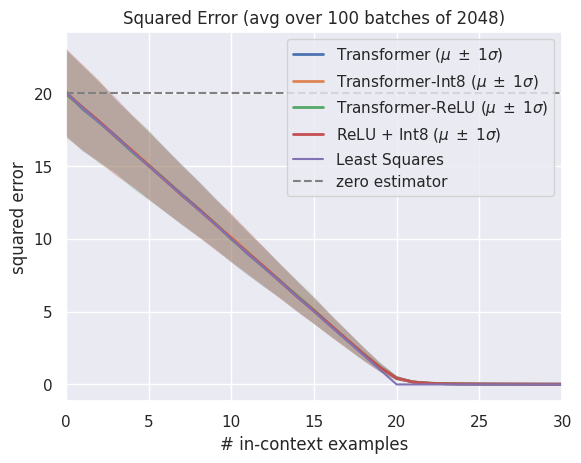

In [7]:
plt.title(f"Squared Error (avg over {RUNS} batches of {BATCH_SIZE})")

oracle = None
if task in optimals.keys():
    oracle = (optimals[task]["label"], optimals[task]["error"])
    
plot_model_errs(errs, baseline=naives[task], optimal=oracle)
plt.xlim(0, 30)
plt.show()

#### Decision Trees

In [8]:
task = "decision_tree"
errs = compute_errs(task, 101)

Running batches: 100%|██████████| 100/100 [11:26<00:00,  6.86s/it]


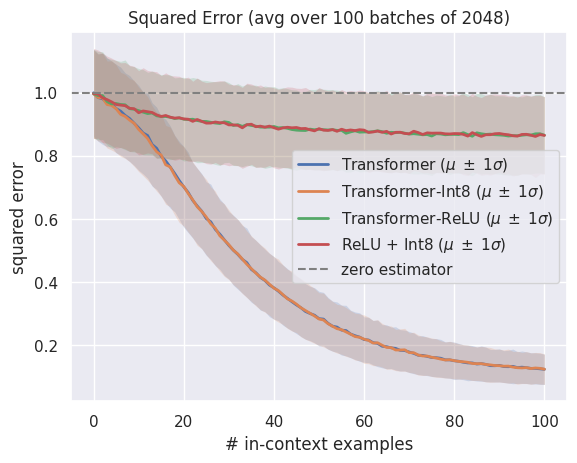

In [9]:
plt.title(f"Squared Error (avg over {RUNS} batches of {BATCH_SIZE})")

oracle = None
if task in optimals.keys():
    oracle = (optimals[task]["label"], optimals[task]["error"])

plot_model_errs(errs, baseline=naives[task], optimal=oracle)

#### Sparse Linear Regression

In [10]:
task = "sparse_linear_regression"
errs = compute_errs(task, 41)

Running batches: 100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


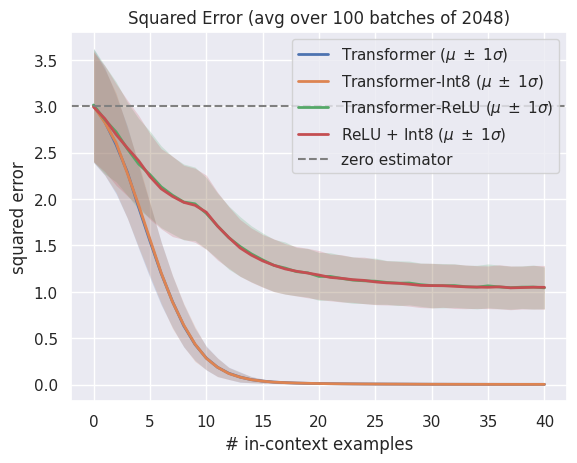

In [11]:
plt.title(f"Squared Error (avg over {RUNS} batches of {BATCH_SIZE})")

oracle = None
if task in optimals.keys():
    oracle = (optimals[task]["label"], optimals[task]["error"])

plot_model_errs(errs, baseline=naives[task], optimal=oracle)

### Doubling Inputs

In [33]:
BATCH_SIZE = 2048
RUNS = 100
double = scale(2)

def compute_errs(task, context_length):
    models = get_trained_models(task)
    errs = {}
    for _, row in models.iterrows():
        errs[row["run_id"]] = get_err_from_run(
            row["run_path"], 
            mutate_xs=double,
            mutate_bs=bs(BATCH_SIZE),
            runs=RUNS,
            ic_examples=context_length
        ).cpu()
    
    return errs
    
    return errs

#### Linear Regression

In [13]:
task = "linear_regression"
errs = compute_errs(task, 41)

Running batches: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


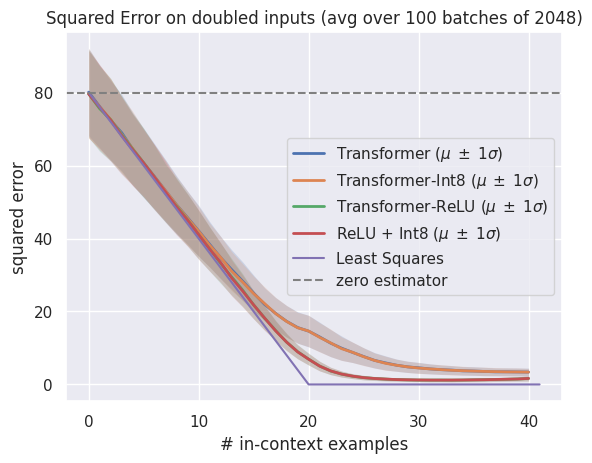

In [14]:
plt.title(f"Squared Error on doubled inputs (avg over {RUNS} batches of {BATCH_SIZE})")

oracle = None
if task in optimals.keys():
    oracle = (optimals[task]["label"], optimals[task]["error"] * double(1)**2)

baseline = naives[task]
if task in ("linear_regression", "sparse_linear_regression"):
    baseline *= double(1)**2
    
plot_model_errs(
    errs,
    baseline=baseline,
    optimal=oracle
    # no_std_dev=True
)

#### Decision Trees

In [34]:
task = "decision_tree"
errs = compute_errs(task, 101)

Running batches: 100%|██████████| 100/100 [11:30<00:00,  6.90s/it]


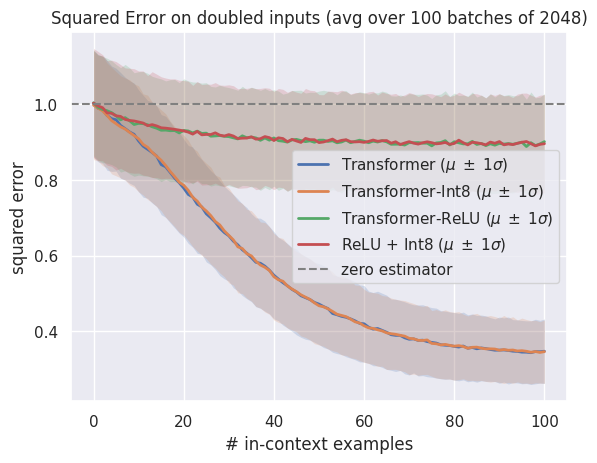

In [35]:
plt.title(f"Squared Error on doubled inputs (avg over {RUNS} batches of {BATCH_SIZE})")

oracle = None
if task in optimals.keys():
    oracle = (optimals[task]["label"], optimals[task]["error"] * double(1)**2)

baseline = naives[task]
if task in ("linear_regression", "sparse_linear_regression"):
    baseline *= double(1)**2
    
plot_model_errs(
    errs,
    baseline=baseline,
    optimal=oracle
    # no_std_dev=True
)

#### Sparse Linear Regression

In [36]:
task = "sparse_linear_regression"
errs = compute_errs(task, 41)

Running batches: 100%|██████████| 100/100 [03:23<00:00,  2.04s/it]


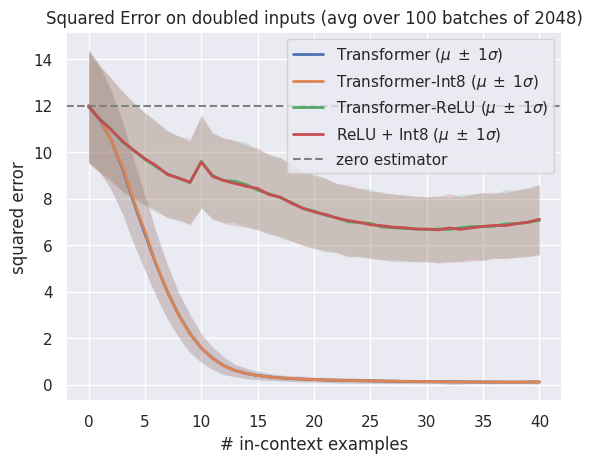

In [37]:
plt.title(f"Squared Error on doubled inputs (avg over {RUNS} batches of {BATCH_SIZE})")

oracle = None
if task in optimals.keys():
    oracle = (optimals[task]["label"], optimals[task]["error"] * double(1)**2)

baseline = naives[task]
if task in ("linear_regression", "sparse_linear_regression"):
    baseline *= double(1)**2
    
plot_model_errs(
    errs,
    baseline=baseline,
    optimal=oracle
    # no_std_dev=True
)

### Halving Inputs

In [38]:
BATCH_SIZE = 2048
RUNS = 100
halve = scale(0.5)

def compute_errs(task, context_length):
    models = get_trained_models(task)
    errs = { 
        row["run_id"] : get_err_from_run(
            row["run_path"], 
            mutate_xs=halve,
            mutate_bs=bs(BATCH_SIZE),
            runs=RUNS,
            ic_examples=context_length
        ).cpu()
        for _, row in models.iterrows() 
    }
    
    return errs

#### Linear Regression

In [39]:
task = "linear_regression"
errs = compute_errs(task, 41)

Running batches: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


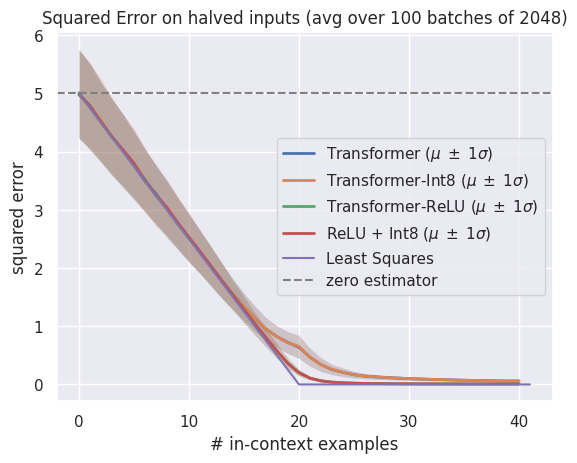

In [40]:
plt.title(f"Squared Error on halved inputs (avg over {RUNS} batches of {BATCH_SIZE})")

oracle = None
if task in optimals.keys():
    oracle = (optimals[task]["label"], optimals[task]["error"] * halve(1)**2)

baseline = naives[task]
if task in ("linear_regression", "sparse_linear_regression"):
    baseline *= halve(1)**2
    
plot_model_errs(
    errs,
    baseline=baseline,
    optimal=oracle
    # no_std_dev=True
)

#### Decision Trees

In [41]:
task = "decision_tree"
errs = compute_errs(task, 101)

Running batches: 100%|██████████| 100/100 [11:28<00:00,  6.88s/it]


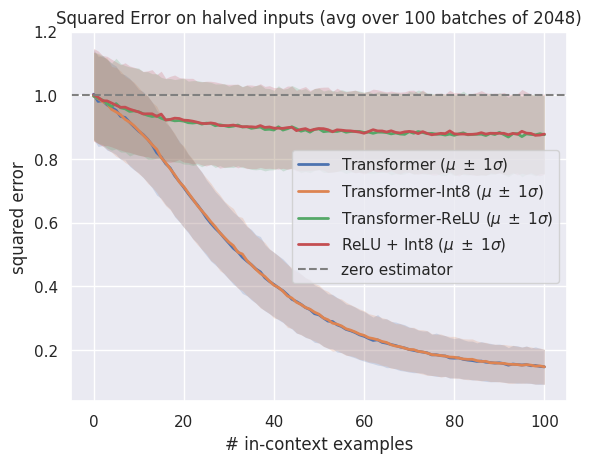

In [42]:
plt.title(f"Squared Error on halved inputs (avg over {RUNS} batches of {BATCH_SIZE})")

oracle = None
if task in optimals.keys():
    oracle = (optimals[task]["label"], optimals[task]["error"] * halve(1)**2)

baseline = naives[task]
if task in ("linear_regression", "sparse_linear_regression"):
    baseline *= halve(1)**2
    
plot_model_errs(
    errs,
    baseline=baseline,
    optimal=oracle
    # no_std_dev=True
)

#### Sparse Linear Regression

In [ ]:
task = "sparse_linear_regression"
errs = compute_errs(task, 41)

Running batches: 100%|██████████| 100/100 [03:23<00:00,  2.04s/it]


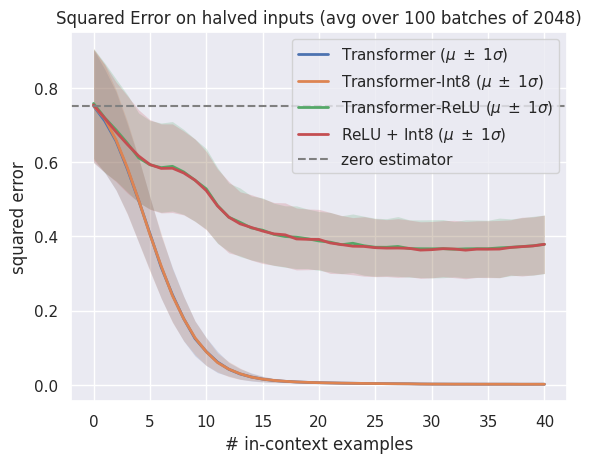

In [ ]:
plt.title(f"Squared Error on halved inputs (avg over {RUNS} batches of {BATCH_SIZE})")

oracle = None
if task in optimals.keys():
    oracle = (optimals[task]["label"], optimals[task]["error"] * halve(1)**2)

baseline = naives[task]
if task in ("linear_regression", "sparse_linear_regression"):
    baseline *= halve(1)**2
    
plot_model_errs(
    errs,
    baseline=baseline,
    optimal=oracle
    # no_std_dev=True
)

### Varying scaling factor

In [52]:
def get_scaling_errs(scales, models, bsize=256, runs=1, ic_examples=None):
    errs = {}
    
    for _, row in models.iterrows():
        print(f"Computing error for {row['model']}")
        err = compute_scaling_err(row['run_path'], mutate_bs=bs(bsize), scales=scales, runs=runs, ic_examples=ic_examples).mean(axis=1)
        errs[row['run_id']] = err

    return errs

In [53]:
def plot_scaling_errs(errs, ic_example_counts, normalize_errs=True, max_y=50, task="linear_regression"):
    fig, ax = plt.subplots(1, len(ic_example_counts), sharey='all')
    fig.set_size_inches(20, 5)
    for i, ic_examples in enumerate(ic_example_counts):
        for run_id, err in errs.items():
            ys = err[:, ic_examples].cpu() / (scales ** 2) if normalize_errs else err[:, ic_examples]
            ax[i].plot(scales, ys, label=get_label(run_id))

        ax[i].set_title(f"Error with {ic_examples} examples")
        ax[i].set_xscale('log')
        ax[i].set_xlabel("Scaling factor")
        ax[i].set_ylim(0, max_y)

        naive = naives[task]
        if task in optimals.keys():
            optim = torch.concat((optimals[task]["error"], torch.zeros((max(ic_example_counts)-19, ))))[ic_examples]
        if normalize_errs: 
            ax[i].axhline(naive, ls="--", color="gray", label="zero estimator")
            if task in optimals.keys():
                ax[i].axhline(optim, ls="--", color="blue", label=optimals[task]["label"])
        else:
            ax[i].set_yscale('log')

            naive *= scales ** 2
            ax[i].plot(naive, ls="--", color="gray", label="zero estimator")
            
            if task in optimals.keys():
                optim *= scales ** 2
                ax[i].plot(optim, ls="--", color="blue", label=optimals[task]["label"])

        if i == 0:
            ax[i].set_ylabel("squared error")

        if i == 0:
            ax[i].legend()

    return fig

#### Linear Regression

In [60]:
scales = np.concatenate((np.arange(0.1, 1, 0.1), np.arange(1, 11.)))
models = get_trained_models("linear_regression")
scaling_errs = get_scaling_errs(scales, models, bsize=2048, runs=10, ic_examples=41)

Computing error for Transformer


Scales computed: 100%|██████████| 19/19 [06:30<00:00, 20.55s/it]


Computing error for Transformer


Scales computed: 100%|██████████| 19/19 [06:29<00:00, 20.51s/it]


Computing error for Transformer-ReLU


Scales computed: 100%|██████████| 19/19 [06:27<00:00, 20.40s/it]


Computing error for Transformer-ReLU


Scales computed: 100%|██████████| 19/19 [06:28<00:00, 20.46s/it]


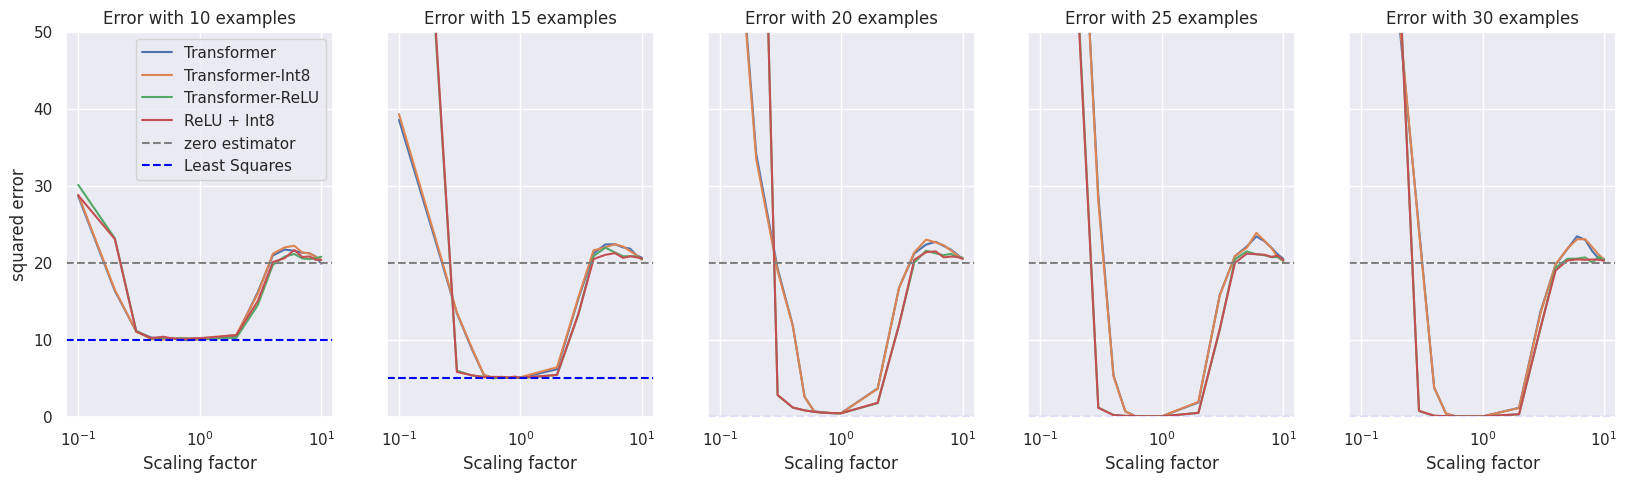

In [61]:
f = plot_scaling_errs(scaling_errs, [10, 15, 20, 25, 30], max_y=50)
f.show()

#### Decision Trees

In [56]:
scales = np.concatenate((np.arange(0.1, 1, 0.1), np.arange(1, 11.)))
models = get_trained_models("decision_tree")
scaling_errs = get_scaling_errs(scales, models, bsize=1024, runs=5, ic_examples=100)

Computing error for Transformer


Scales computed: 100%|██████████| 19/19 [05:16<00:00, 16.64s/it]


Computing error for Transformer


Scales computed: 100%|██████████| 19/19 [05:16<00:00, 16.66s/it]


Computing error for Transformer-ReLU


Scales computed: 100%|██████████| 19/19 [05:19<00:00, 16.82s/it]


Computing error for Transformer-ReLU


Scales computed: 100%|██████████| 19/19 [05:19<00:00, 16.80s/it]


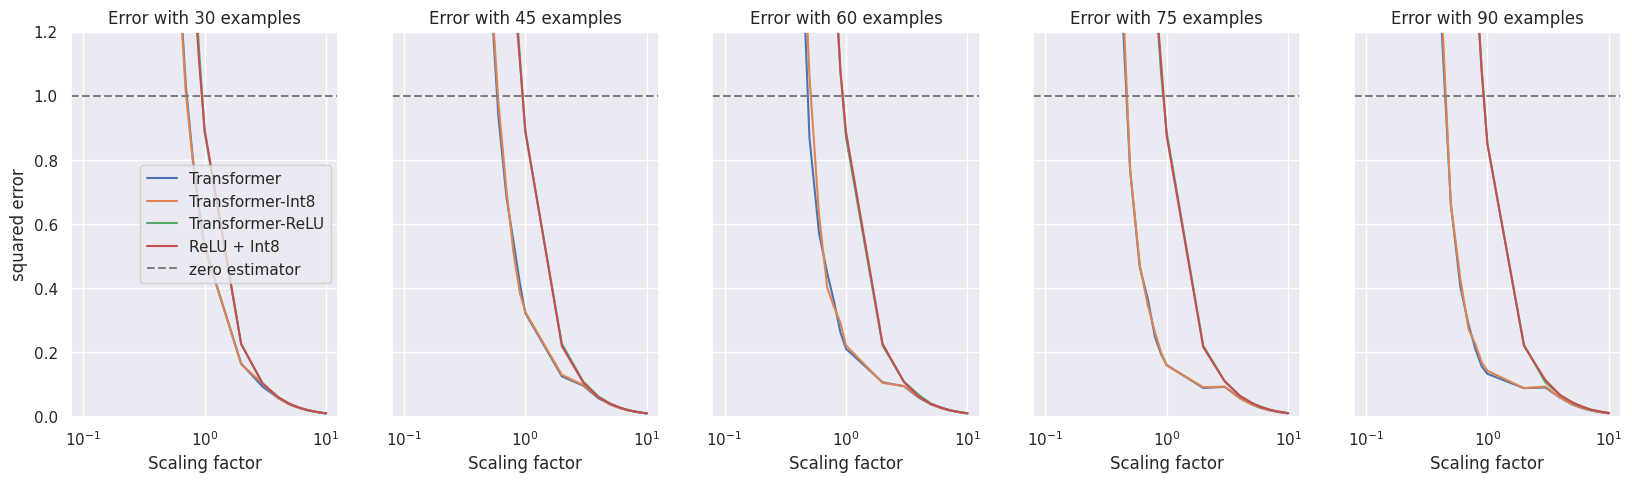

In [57]:
f = plot_scaling_errs(scaling_errs, [30, 45, 60, 75, 90], max_y=1.2, task="decision_tree")
f.show()

#### Sparse Linear Regression

In [58]:
scales = np.concatenate((np.arange(0.1, 1, 0.1), np.arange(1, 11.)))
models = get_trained_models("sparse_linear_regression")
scaling_errs = get_scaling_errs(scales, models, bsize=1024, runs=5, ic_examples=41)

Computing error for Transformer


Scales computed: 100%|██████████| 19/19 [01:51<00:00,  5.85s/it]


Computing error for Transformer


Scales computed: 100%|██████████| 19/19 [01:50<00:00,  5.81s/it]


Computing error for Transformer-ReLU


Scales computed: 100%|██████████| 19/19 [01:50<00:00,  5.80s/it]


Computing error for Transformer-ReLU


Scales computed: 100%|██████████| 19/19 [01:49<00:00,  5.79s/it]


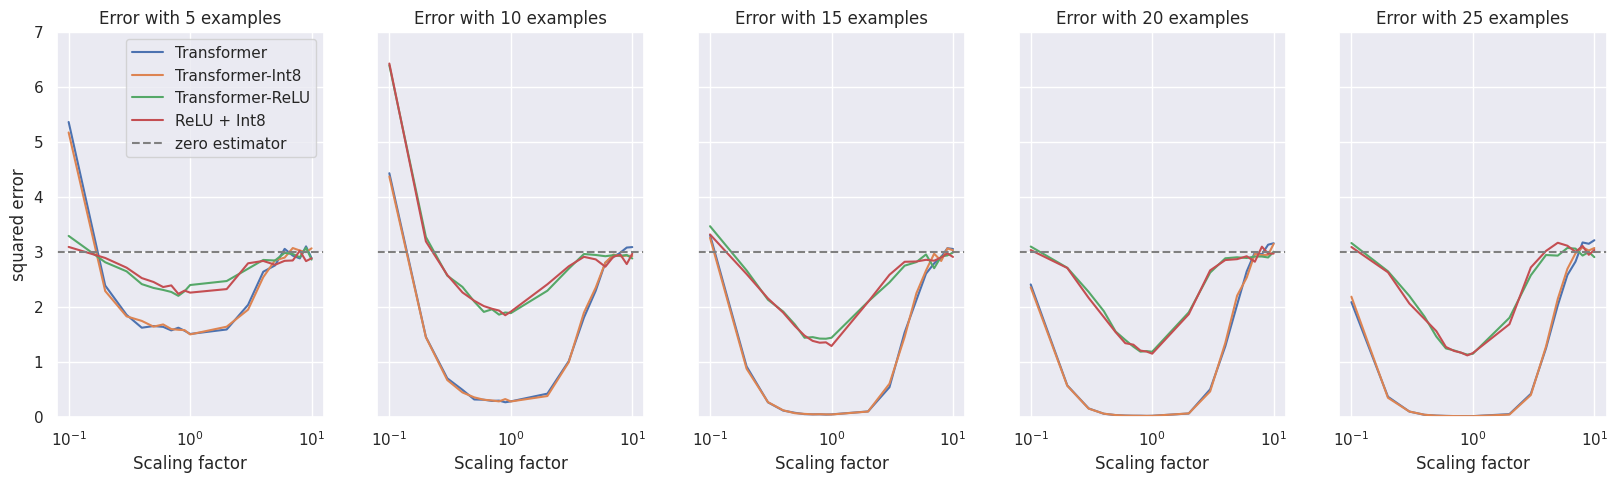

In [59]:
# Linear Reg
plot_scaling_errs(scaling_errs, [5, 10, 15, 20, 25], max_y=7, task="sparse_linear_regression").show()

### Inference time

In [4]:
models = get_trained_models("linear_regression")
BATCHES = [32, 64, 128, 256, 512, 1024, 2048, 4096]
RUNS = 15

run_data = {
    row["run_id"] : {
        "path" : row["run_path"],
        "errs" : [], "times" : []
    } for _, row in models.iterrows()
}

for batch in BATCHES:
    print(f"Running batch size of {batch} ... ", end='')
    for model_type in run_data.keys():
        err, time = get_timed_err_from_run(run_data[model_type]["path"], mutate_bs=(lambda bs: batch), runs=RUNS)
        
        run_data[model_type]['errs'].append(err.cpu())
        run_data[model_type]['times'].append(time)

for model_type in run_data.keys():
    run_data[model_type]['errs'] = torch.stack(run_data[model_type]['errs']).cpu()

Running batch size of 32 ... 

Timing runs: 100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


Running batch size of 64 ... 

Timing runs: 100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


Running batch size of 128 ... 

Timing runs: 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Running batch size of 256 ... 

Timing runs: 100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Running batch size of 512 ... 

Timing runs: 100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


Running batch size of 1024 ... 

Timing runs: 100%|██████████| 15/15 [00:25<00:00,  1.68s/it]


Running batch size of 2048 ... 

Timing runs: 100%|██████████| 15/15 [00:40<00:00,  2.73s/it]


Running batch size of 4096 ... 

Timing runs: 100%|██████████| 15/15 [01:12<00:00,  4.84s/it]


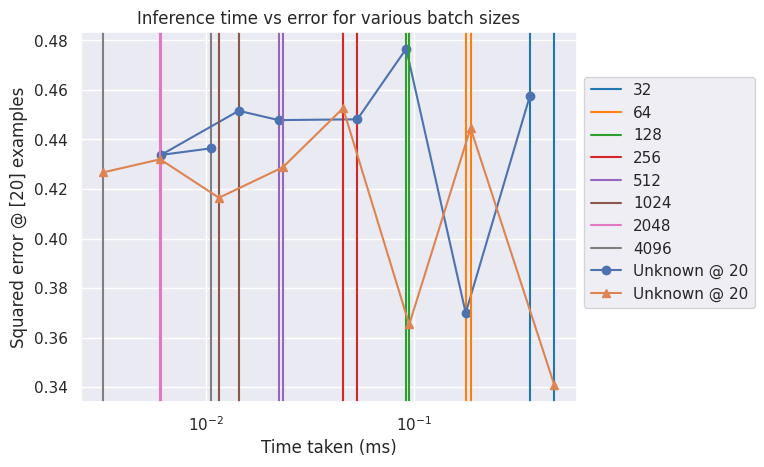

In [67]:
IC_EXAMPLES = [20]
colors=["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan",  "black", "red"]
markers = ["o", "^", "." , "s" , "P" , "v" , "1", "3", "*", "x", "d", "X", "8"]

for i, (marker, model_type) in enumerate(zip(markers, run_data.keys())):
    x = np.array(run_data[model_type]["times"]).mean(axis=1)  * 1e3
    y = run_data[model_type]["errs"][:, IC_EXAMPLES]
    
    for batch_time, ic, color in zip(x, BATCHES, colors):
        if i == 0:
            plt.axvline(batch_time, color=color, label=ic)
        else:
            plt.axvline(batch_time, color=color)

    for ic, errs in zip(IC_EXAMPLES, y.T):
        plt.plot(x, errs.cpu().numpy(), marker=marker, label=f"{get_label(model_type)} @ {ic}")
    
plt.xscale('log')
plt.title(f"Inference time vs error for various batch sizes")
plt.xlabel("Time taken (ms)")
plt.ylabel(f"Squared error @ {IC_EXAMPLES} examples")
plt.legend(bbox_to_anchor=(1., 0.9))

In [88]:
RUNS = 200
TIMING_BATCH_SIZE = 2048

fixed_batch_size = lambda bs: TIMING_BATCH_SIZE

# relu_abs_loss, time_relu = get_timed_err_from_run(run_path, mutate_bs=fixed_batch_size, runs=RUNS)
# vanil_abs_loss, time_vanil = get_timed_err_from_run("../models/linear_regression/pretrained", mutate_bs=fixed_batch_size, runs=RUNS)

d = {}
for _, row in models.iterrows():
    err, time = get_timed_err_from_run(row["run_path"], mutate_bs=bs(TIMING_BATCH_SIZE), runs=RUNS)
    d[row["run_id"]] = {
        "errs" : err,
        "times": time
    }

with open("losses_and_times.pkl", 'wb') as f:
    pickle.dump(d, f)

Timing runs: 100%|██████████| 200/200 [09:09<00:00,  2.75s/it]


In [89]:
with open("losses_and_times.pkl", "rb") as f:
    d = pickle.load(f)

In [90]:
out = {}
for run_id, vals in d.items():
    ts = vals["times"]
    iqr = np.quantile(ts, .75) - np.quantile(ts, .25)
    upper_bound = iqr * 1.5 + np.quantile(ts, .75)
    valid = vals["times"] <= upper_bound
    
    out[run_id] = np.array(vals["times"])[valid]

In [91]:
def format_times(times, title):
    print(title, f"(count: {times.shape}, mean: {np.mean(times)*1e3} +- {np.std(times)*1e3})")
format_times(out["pretrained_relu"], "ReLU Times :")
format_times(out["pretrained"], "Vanil Times:")
format_times(out["pretrained_quantized"], "Quant Times :")
format_times(out["pretrained_relu_quantized"], "ReLU Quant Times:")

ReLU Times : (count: (174,), mean: 0.005256981577161923 +- 0.00021653392891549843)
Vanil Times: (count: (175,), mean: 0.0051484631891339306 +- 0.00026625494577172944)
Quant Times : (count: (170,), mean: 0.005125696355137547 +- 0.00021765201852024616)
ReLU Quant Times: (count: (176,), mean: 0.0051689393561734935 +- 0.0002670077278740225)


Text(0.5, 0, 'Time (s)')

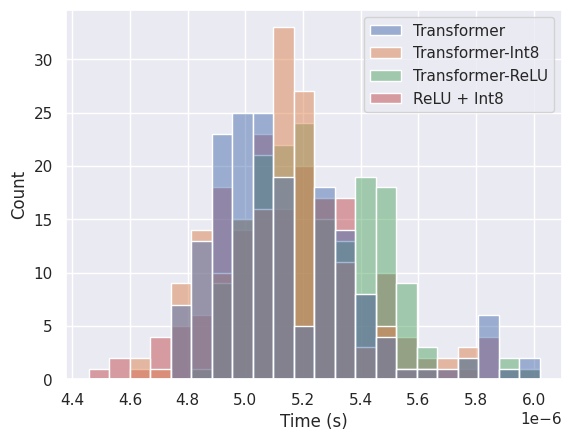

In [92]:
sns.histplot({
    get_label(run_id) : vals
    for run_id, vals in out.items()
})
plt.xlabel("Time (s)")